# **Learning over image data**

In [2]:
import os
import glob
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
import torchvision.models as models

from gridnext.densenet import DenseNet
from gridnext.gridnet_models import GridNetHexOddr
from gridnext.visium_datasets import create_visium_dataset
from gridnext.training import train_spotwise, train_gridwise
from gridnext.utils import all_fgd_predictions, to_loupe_annots
from gridnext.plotting import performance_curves

In [3]:
# training dataset
data_dir = r'D:\smarrakchi\Gridnet_UCAN_data\2nd_run'

spaceranger_dirs = sorted(glob.glob(os.path.join(data_dir, 'spaceranger', '*')))
fullres_image_files = sorted(glob.glob(os.path.join(data_dir, 'fullres_images', '*.jpg')))
annot_files = sorted(glob.glob(os.path.join(data_dir, 'annotations', '*.csv')))

#print("Spaceranger directories:", spaceranger_dirs)
#print("Full resolution image files:", fullres_image_files)
#print("Annotation files:", annot_files)


In [3]:
# Partition data into training and validation folders:
# with n_val = n we use every element in these folders for training except the first n elements, and use the first n elements  for validatio
seed = 126
np.random.seed(seed)
mask = np.random.permutation(len(spaceranger_dirs))


n_val = 10
max = 50
train_srd = np.array(spaceranger_dirs)[mask][n_val:]
train_img = np.array(fullres_image_files)[mask][n_val:]
train_ann = np.array(annot_files)[mask][n_val:]

val_srd = np.array(spaceranger_dirs)[mask][:n_val]
val_img = np.array(fullres_image_files)[mask][:n_val]
val_ann = np.array(annot_files)[mask][:n_val]

## 0. Image data pre-processing

In [4]:
# Custom transformations - setting probability of transformation being applied to 0.5 to keep it balanced
#hsv_light = HSV_light(
#    adjust_hue=0.5, 
#    adjust_brightness=0.5, 
#    adjust_contrast=0.5, 
#    adjust_gamma=0.5,                 
#    adjust_saturation=0.5, 
#    adjust_sharpness=0.5,
#    range_distribution="uniform")

#random_rot90 = RandomRot90(p=0.5)

### DID NOT END UOP USING THE CUSTOM TRANSFORMS 

# Image transforms for training data, with augmentation
train_transforms = transforms.Compose([
    transforms.Resize(256),  # Resizes the image
    transforms.CenterCrop(224),  # Crops the center
    transforms.ColorJitter(
        brightness=0.5,  # Randomly change brightness
        contrast=0.5,    # Randomly change contrast
        saturation=0.5,  # Randomly change saturation
        hue=0.1          # Randomly change hue
    ),
    transforms.RandomRotation(degrees=90),  # Randomly rotate the image by 90 degrees
    transforms.ToTensor(),  # Converts image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Image transforms for validation data, no augmentation
val_transforms = transforms.Compose([
    transforms.Resize(256),  # Resizes the image
    transforms.CenterCrop(224),  # Crops the center
    transforms.ToTensor(),  # Converts image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

patch_size = (3,224,224)

## 1. Training spot classifier

In [5]:

# Create training and validation datasets
train_pdat = create_visium_dataset(train_srd, annot_files=train_ann, fullres_image_files=train_img,
                                   use_count=False, use_image=True, spatial=False,
                                   img_transforms=train_transforms)

val_pdat = create_visium_dataset(val_srd, annot_files=val_ann, fullres_image_files=val_img,
                                 use_count=False, use_image=True, spatial=False, 
                                 img_transforms=val_transforms)

print('%d training and %d validation spots' % (len(train_pdat), len(val_pdat)))

train_class_names = train_pdat.classes
val_class_names = val_pdat.classes
print('%d classes' % len(train_class_names))
print('%d classes' % len(val_class_names))


199766 training and 19658 validation spots
17 classes
17 classes


### Note about image -> tensor conversion:

Converting an image to a tensor is a process that transforms the image data into a format suitable for computation in machine learning frameworks like PyTorch. Here’s a detailed explanation of what it means:

Representation of Image Data:
Images are typically represented as multi-dimensional arrays (matrices) where each element corresponds to a pixel value.
For color images, this representation often includes three color channels (Red, Green, Blue), leading to a 3D array: (height,width,channels).

Conversion to Tensor:
A tensor is a multi-dimensional array similar to NumPy arrays but optimized for automatic differentiation and GPU acceleration, making it essential for deep learning.
Converting an image to a tensor involves reformatting this multi-dimensional array into a data structure that PyTorch (or other frameworks) can work with efficiently.
Steps in transforms.ToTensor():

Rearranging Dimensions:
The typical arrangement for an image in libraries like PIL (Python Imaging Library) is (height,width,channels).
transforms.ToTensor() rearranges this to (channels,height,width) because PyTorch expects tensors in this order.

Scaling Pixel Values:
Pixel values in an image are usually in the range [0, 255].
transforms.ToTensor() scales these values to the range [0, 1] by dividing each pixel value by 255.

In [35]:
# sanity check since we once didn't have all 17 AAR classes represented in the validation dataset
train_pdat.classes == val_pdat.classes

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [7]:
# check that we have a balanced number of spots per class
def count_all_column_values(folder_path, column_name, file_names):
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    # Convert the list of filenames to a set for faster lookups
    file_names_set = set(file_names)
    
    overall_counter = Counter()
    
    for file_path in csv_files:
        # Get the filename from the file path
        filename = os.path.basename(file_path)
        
        # Only process files that are in the specified array
        if filename in file_names_set:
            # Read each CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            if column_name in df.columns:
                # Count the occurrences of each value in the specified column
                value_counts = df[column_name].value_counts()
                for value, count in value_counts.items():
                    overall_counter[value] += count
            else:
                print(f"Column '{column_name}' not found in {file_path}. Skipping file.")
    
    return overall_counter

# Path to the folder containing the CSV files
folder_path =  r'D:\smarrakchi\Gridnet_UCAN_data\2nd_run\annotations'
# Name of the column to count values in
column_name = 'AARs'
# List of filenames to process
file_names = train_ann

# Get the counts of all values in the specified column across the specified CSV files
counts = count_all_column_values(folder_path, column_name, file_names)

# Print the counts of each value
for value, count in counts.items():
    print(f"{value}: {count}")


In [6]:
def count_all_column_values(folder_path, column_name):
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    overall_counter = Counter()
    
    for file_path in csv_files:
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        if column_name in df.columns:
            # Count the occurrences of each value in the specified column
            value_counts = df[column_name].value_counts()
            for value, count in value_counts.items():
                overall_counter[value] += count
        else:
            print(f"Column '{column_name}' not found in {file_path}. Skipping file.")
    
    return overall_counter

# Path to the folder containing the CSV files
folder_path =  r'D:\smarrakchi\Gridnet_UCAN_data\2nd_run\annotations'
# Name of the column to count values in
column_name = 'AARs'

# Get the counts of all values in the specified column across all CSV files
counts = count_all_column_values(folder_path, column_name)

# Print the counts of each value
for value, count in counts.items():
    print(f"{value}: {count}")


Muscle: General: 32211
Submucosa: General: 46232
Mucosa: Mid: 6843
Mucosa: Cross-Mucosa: 27016
Mucosa: Base: 2590
Mucosa: Apex: 5046
Submucosa: Lamina Propria: 4916
Submucosa: Vessels: 6005
Submucosa: Lymphoid Aggregates: 1395
Tumor: Polyps: 1567
Tumor: Transitional: 25125
Tumor Stroma: Fibromuscular: 30902
Submucosa: Adipose Tissue: 3551
Tumor Stroma: Immune-infiltrated: 8176
Tumor: Undifferentiated: 16185
Tumor: Glandular: 7538
Tumor: Necrotic: 11039


In [7]:
# Create data loaders for training loop
# creates two DataLoader objects in a dictionary to handle data loading for training and validation datasets in a PyTorch framework.

dataloader_spots = {
    'train': DataLoader(train_pdat, batch_size=32, shuffle=True),
    'val': DataLoader(val_pdat, batch_size=32)
}

# So: the dictionary dataloader_spots has two keys: 'train' and 'val'. Each key is associated with a dataloader object.
# batch_size=32: Specifies that the data should be loaded in batches of 32 samples.
# shuffle=True: Ensures that the data is shuffled at the beginning of each epoch, 
# which helps to improve the training by providing different batches of data in each epoch.

In [8]:
class fully_connected(nn.Module):
	"""docstring for BottleNeck"""
	def __init__(self, model, num_ftrs, num_classes):
		super(fully_connected, self).__init__()
		self.model = model
		self.fc_4 = nn.Linear(num_ftrs,num_classes)

	def forward(self, x):
		x = self.model(x)
		x = torch.flatten(x, 1)
		out_3 = self.fc_4(x)
		return  out_3
	

model = models.densenet121(pretrained=False)

model.features = nn.Sequential(model.features , nn.AdaptiveAvgPool2d(output_size= (1,1)))

num_ftrs = model.classifier.in_features
model_final = fully_connected(model.features, num_ftrs, 17)
model_final = nn.DataParallel(model_final)
dict_=torch.load(r'C:/Users/smarrakchi/Desktop/KimiaNetPyTorchWeights.pth',weights_only=True)
dict_["module.fc_4.bias"]=(2*torch.rand(17)-1).to("cuda:0")
dict_["module.fc_4.weight"]=(2*torch.rand(17,1024)-1).to("cuda:0")
model_final.load_state_dict(dict_)

c:\Users\smarrakchi\.conda\envs\gridnext\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\smarrakchi\.conda\envs\gridnext\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [10]:
# Instantiate DenseNet to be used as spot classifier (f)
f = model_final

In [11]:
# Perform model training and save parameters

loss = nn.CrossEntropyLoss()
#This sets up the loss function for classification tasks. 
# CrossEntropyLoss is commonly used for multi-class classification problems, 
# where it computes the difference between the predicted class probabilities and the actual class labels.

optimizer = torch.optim.Adam(f.parameters(), lr=1e-4) # change to e-4 next try
# This initializes the Adam optimizer for the model f. 
# Adam is an optimization algorithm that adjusts the learning rate dynamically. 
# f.parameters() provides the parameters of the model to be optimized. lr=1e-3 sets the learning rate to 0.001.

output_dir = '/Users/smarrakchi/Desktop/models'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
# This creates a directory named models one level up from the current directory if it does not already exist. 
# This directory will be used to save the trained model's parameters.

outfile = os.path.join(output_dir, 'f_img.pth')

f, f_val_hist, f_train_hist = train_spotwise(f, dataloader_spots, loss, optimizer, 
                                             num_epochs=50, display=False, outfile=outfile)
# This calls a custom function train_spotwise to train the model f.
# f: The model to be trained.
# dataloader_spots: Dictionary containing DataLoader objects for training and validation data.
# loss: The loss function (CrossEntropyLoss).
# optimizer: The optimizer (Adam).
# num_epochs=10: The number of epochs for training the model.
# display=False: Whether to display training progress (set to False in this case).
# outfile: Path to save the trained model's parameters.
# The function train_spotwise will return:
#f: The trained model.
#f_val_hist: History of validation metrics during training.
#f_train_hist: History of training metrics during training.

Epoch 0/49
----------
train Loss: 1.5400 Acc: 0.6305
val Loss: 1.3259 Acc: 0.6366

Epoch 1/49
----------
train Loss: 0.7222 Acc: 0.7616
val Loss: 1.1172 Acc: 0.6631

Epoch 2/49
----------
train Loss: 0.6024 Acc: 0.7992
val Loss: 1.1845 Acc: 0.6700

Epoch 3/49
----------
train Loss: 0.5388 Acc: 0.8189
val Loss: 1.3685 Acc: 0.6781

Epoch 4/49
----------
train Loss: 0.4949 Acc: 0.8326
val Loss: 1.2385 Acc: 0.6620

Epoch 5/49
----------
train Loss: 0.4613 Acc: 0.8441
val Loss: 1.0651 Acc: 0.7280

Epoch 6/49
----------
train Loss: 0.4353 Acc: 0.8519
val Loss: 1.2399 Acc: 0.7003

Epoch 7/49
----------
train Loss: 0.4150 Acc: 0.8585
val Loss: 1.2677 Acc: 0.6900

Epoch 8/49
----------
train Loss: 0.3953 Acc: 0.8650
val Loss: 1.3722 Acc: 0.6927

Epoch 9/49
----------
train Loss: 0.3788 Acc: 0.8697
val Loss: 1.4444 Acc: 0.6737

Epoch 10/49
----------
train Loss: 0.3648 Acc: 0.8748
val Loss: 1.1976 Acc: 0.7050

Epoch 11/49
----------
train Loss: 0.3523 Acc: 0.8781
val Loss: 1.2832 Acc: 0.6905

Ep

## 2. Training spatial corrector network

In [32]:
# Create training and validation datasets
train_gdat = create_visium_dataset(train_srd, annot_files=train_ann, fullres_image_files=train_img,
                                   use_count=False, use_image=True, spatial=True,
                                   img_transforms=train_transforms)
val_gdat = create_visium_dataset(val_srd, annot_files=val_ann, fullres_image_files=val_img,
                                 use_count=False, use_image=True, spatial=True, 
                                 img_transforms=val_transforms)
print('%d training and %d validation arrays' % (len(train_gdat), len(val_gdat)))

train_class_names = train_gdat.classes
val_class_names = val_gdat.classes
print('%d classes' % len(train_class_names))
print('%d classes' % len(val_class_names))

88 training and 10 validation arrays
17 classes
17 classes


In [34]:
# Create data loaders for training loop
dataloader_grids = {
    'train': DataLoader(train_gdat, batch_size=1, shuffle=True),
    'val': DataLoader(val_gdat, batch_size=1)
}

In [35]:
# Instantiate g network
H_VISIUM = 78
W_VISIUM = 64

g = GridNetHexOddr(f, patch_size, (H_VISIUM, W_VISIUM), n_classes=len(train_class_names), 
                   use_bn=True, atonce_patch_limit=32)

In [36]:
# Train g network
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(g.corrector.parameters(), lr=1e-4) 

# Fixing the parameters of the patch classifier allows slightly faster training, even when only
# optimizing the parameters of the corrector. 
for param in g.patch_classifier.parameters():
    param.requires_grad = False

outfile = os.path.join(output_dir, 'g_img.pth')

g, g_val_hist, g_train_hist = train_gridwise(g, dataloader_grids, loss, optimizer, 
                                             num_epochs=50, outfile=outfile)

Epoch 0/49
----------
train Loss: 3.4152 Acc: 0.0957
val Loss: 3.2936 Acc: 0.0939

Epoch 1/49
----------
train Loss: 2.5769 Acc: 0.2070
val Loss: 2.4969 Acc: 0.2486

Epoch 2/49
----------
train Loss: 2.1387 Acc: 0.3605
val Loss: 2.1359 Acc: 0.4114

Epoch 3/49
----------
train Loss: 1.8905 Acc: 0.4526
val Loss: 1.9588 Acc: 0.4667

Epoch 4/49
----------
train Loss: 1.7289 Acc: 0.5034
val Loss: 1.8392 Acc: 0.5084

Epoch 5/49
----------
train Loss: 1.6112 Acc: 0.5313
val Loss: 1.8058 Acc: 0.5405

Epoch 6/49
----------
train Loss: 1.5260 Acc: 0.5530
val Loss: 1.7920 Acc: 0.5293

Epoch 7/49
----------
train Loss: 1.4490 Acc: 0.5736
val Loss: 1.6357 Acc: 0.5681

Epoch 8/49
----------
train Loss: 1.3778 Acc: 0.5936
val Loss: 1.6034 Acc: 0.5655

Epoch 9/49
----------
train Loss: 1.3135 Acc: 0.6110
val Loss: 1.5577 Acc: 0.5803

Epoch 10/49
----------
train Loss: 1.2597 Acc: 0.6263
val Loss: 1.4991 Acc: 0.5844

Epoch 11/49
----------
train Loss: 1.2113 Acc: 0.6393
val Loss: 1.4939 Acc: 0.5892

Ep

## 3. Visualizing performance

### 3.1 Training/validation error over time

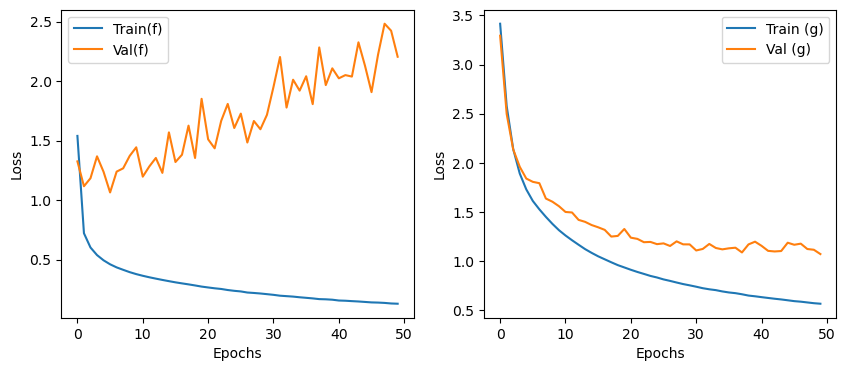

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(f_train_hist, label='Train(f)')
ax[0].plot(f_val_hist, label='Val(f)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(g_train_hist, label='Train (g)')
ax[1].plot(g_val_hist, label='Val (g)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

### 3.2 Performance curves

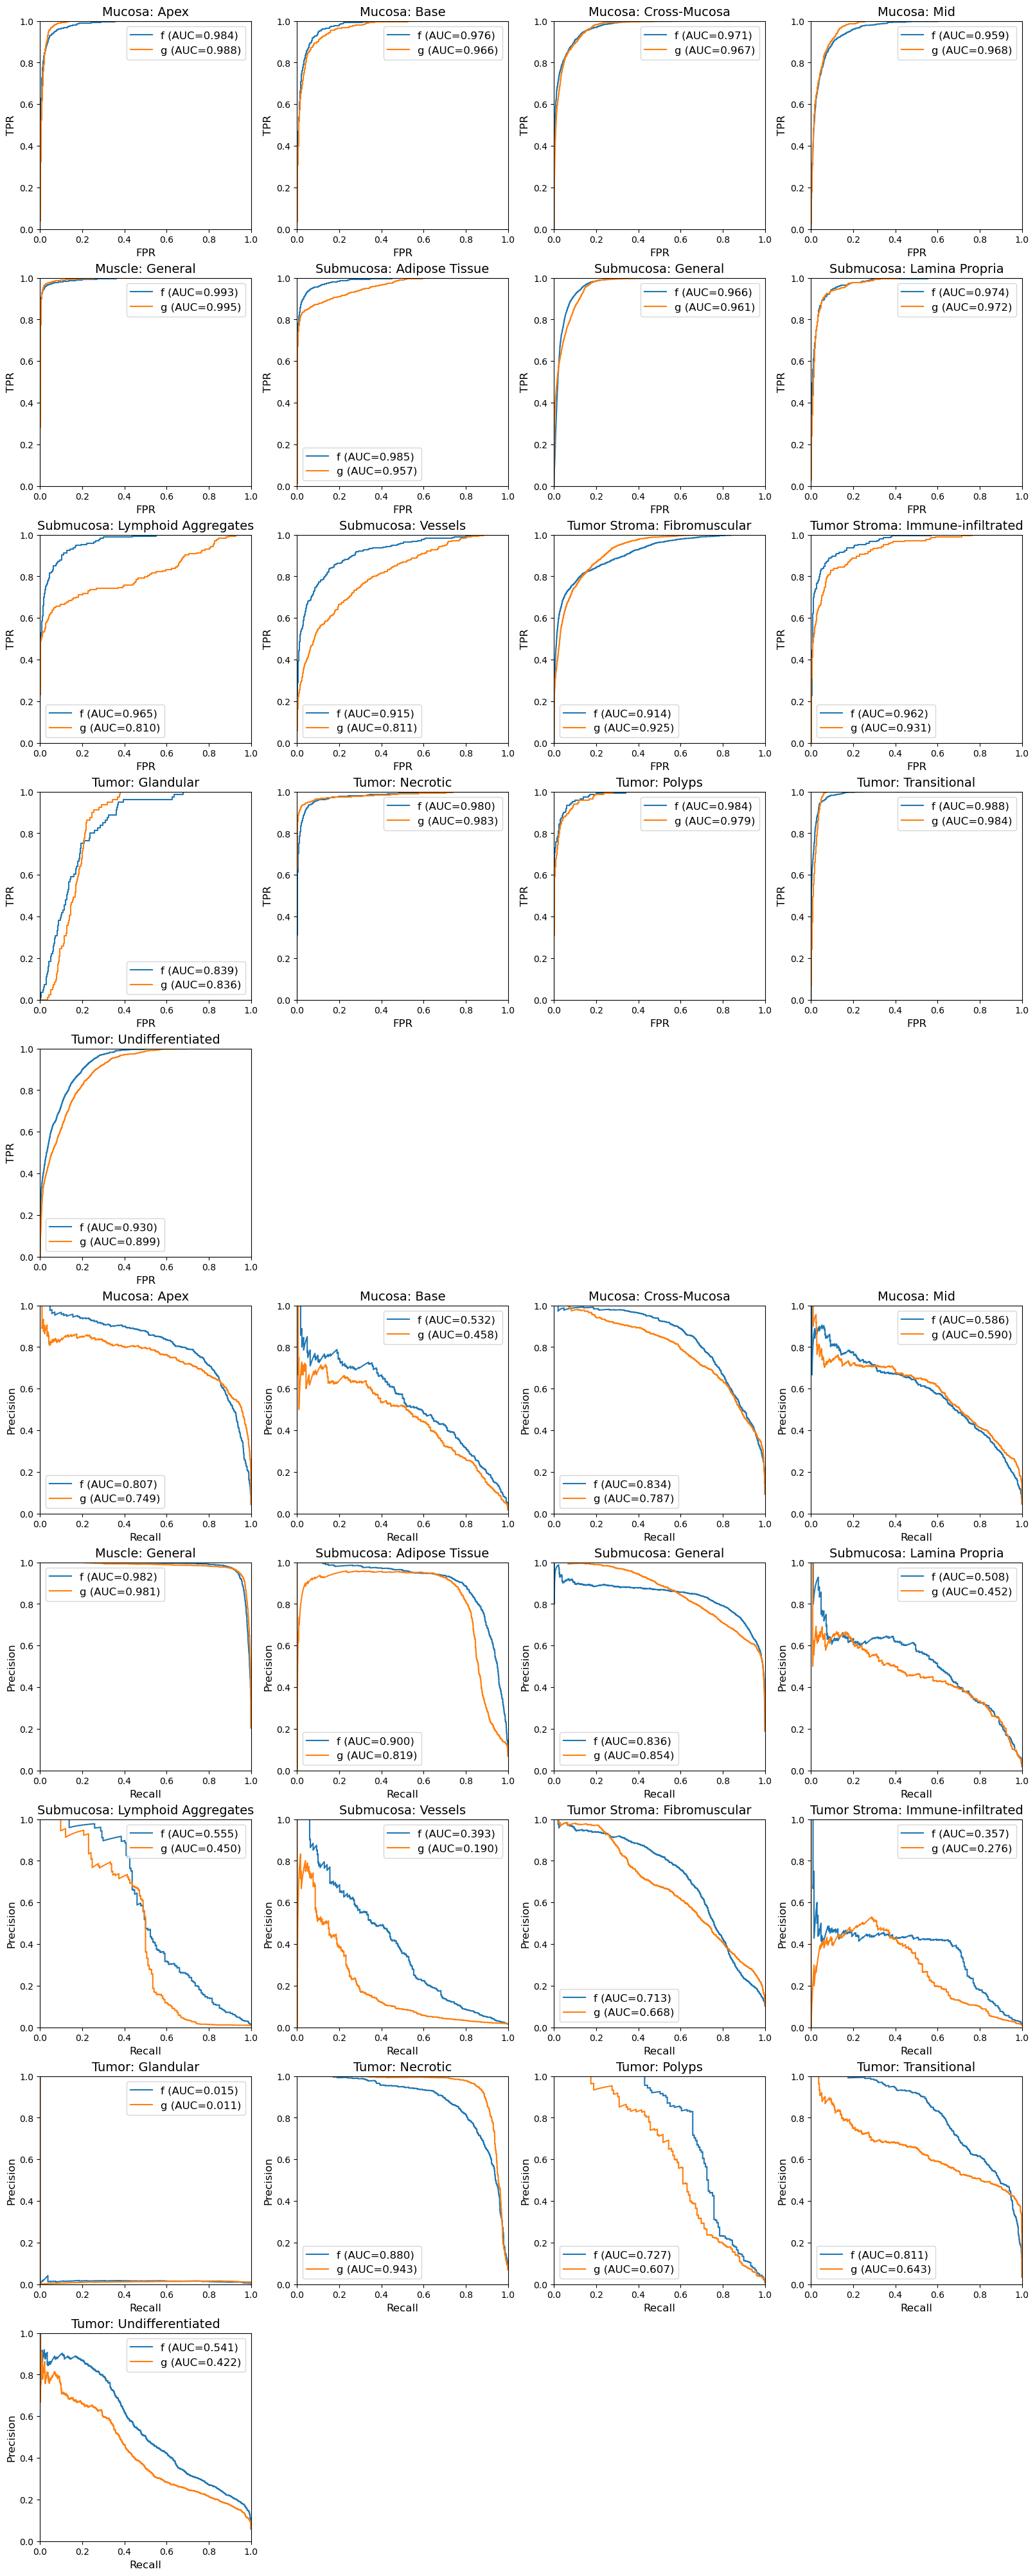

In [40]:
# Performance curves (ROC, precision-recall)
true_vals, f_preds, f_smax = all_fgd_predictions(dataloader_grids['val'], g, f_only=True)
true_vals, g_preds, g_smax = all_fgd_predictions(dataloader_grids['val'], g, f_only=False)

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [f_smax, g_smax], train_class_names, ['f', 'g'])


### 3.3 Exporting predicted annotations as loupe file

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g.to(device)
g.eval()

annot_dir = r'C:\Users\smarrakchi\Desktop\Outputs'
if not os.path.exists(annot_dir):
    os.mkdir(annot_dir)

for i in range(len(val_gdat)):
    x, _ = val_gdat[i]
    x = x.to(device)
    pos_file = val_gdat.position_files[i]
    arr_name = pos_file.split('\\')[-4]

    with torch.no_grad():
        y_pred = g(x).squeeze()  # remove (unit) batch dimension
        label_pred = torch.argmax(y_pred, axis=0)
        to_loupe_annots(label_pred, pos_file, os.path.join(annot_dir, arr_name+'_imgpred.csv'), annot_names=class_names)